## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

!pip install numpy==1.23.3

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
fatal: destination path 'mae' already exists and is not an empty directory.


### Define utils

In [9]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

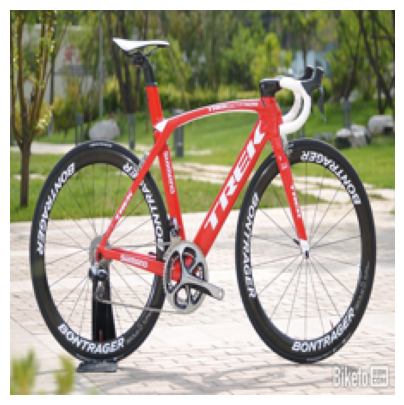

In [17]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = 'http://c2.biketo.com/d/file/edge/knowledge/2016-01-08/c8dec072c6e58bc8ad302d0602a50344.jpg'
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [19]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


--2024-11-26 15:19:48--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_huge.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.202.73, 18.244.202.103, 18.244.202.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.202.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2628481101 (2.4G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_huge.pth’

mae_visualize_vit_h 100%[===================>]   2.45G  40.4MB/s    in 36s     

2024-11-26 15:20:24 (69.3 MB/s) - ‘mae_visualize_vit_huge.pth’ saved [2628481101/2628481101]



<ipython-input-9-4a1bff3e6bef>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


RuntimeError: Error(s) in loading state_dict for MaskedAutoencoderViT:
	size mismatch for cls_token: copying a param with shape torch.Size([1, 1, 1280]) from checkpoint, the shape in current model is torch.Size([1, 1, 1024]).
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 257, 1280]) from checkpoint, the shape in current model is torch.Size([1, 197, 1024]).
	size mismatch for decoder_pos_embed: copying a param with shape torch.Size([1, 257, 512]) from checkpoint, the shape in current model is torch.Size([1, 197, 512]).
	size mismatch for patch_embed.proj.weight: copying a param with shape torch.Size([1280, 3, 14, 14]) from checkpoint, the shape in current model is torch.Size([1024, 3, 16, 16]).
	size mismatch for patch_embed.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.0.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.0.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.0.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.1.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.1.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.1.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.2.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.2.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.2.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.3.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.3.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.3.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.4.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.4.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.4.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.5.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.5.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.5.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.6.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.6.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.6.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.6.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.6.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.6.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.6.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.7.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.7.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.7.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.7.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.7.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.7.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.7.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.8.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.8.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.8.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.8.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.8.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.8.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.8.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.9.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.9.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.9.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.9.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.9.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.9.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.9.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.10.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.10.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.10.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.10.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.10.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.10.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.10.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.11.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.11.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.11.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.11.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.11.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.11.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.11.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.12.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.12.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.12.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.12.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.12.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.12.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.12.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.13.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.13.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.13.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.13.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.13.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.13.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.13.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.14.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.14.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.14.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.14.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.14.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.14.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.14.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.15.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.15.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.15.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.15.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.15.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.15.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.15.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.16.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.16.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.16.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.16.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.16.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.16.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.16.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.17.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.17.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.17.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.17.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.17.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.17.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.17.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.18.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.18.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.18.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.18.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.18.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.18.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.18.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.19.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.19.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.19.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.19.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.19.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.19.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.19.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.20.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.20.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.20.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.20.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.20.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.20.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.20.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.21.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.21.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.21.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.21.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.21.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.21.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.21.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.22.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.22.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.22.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.22.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.22.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.22.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.22.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.norm1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.norm1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.attn.qkv.weight: copying a param with shape torch.Size([3840, 1280]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for blocks.23.attn.qkv.bias: copying a param with shape torch.Size([3840]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for blocks.23.attn.proj.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.23.attn.proj.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.norm2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.norm2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.23.mlp.fc1.weight: copying a param with shape torch.Size([5120, 1280]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.23.mlp.fc1.bias: copying a param with shape torch.Size([5120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.23.mlp.fc2.weight: copying a param with shape torch.Size([1280, 5120]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.23.mlp.fc2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for norm.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for norm.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder_embed.weight: copying a param with shape torch.Size([512, 1280]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder_pred.weight: copying a param with shape torch.Size([588, 512]) from checkpoint, the shape in current model is torch.Size([768, 512]).
	size mismatch for decoder_pred.bias: copying a param with shape torch.Size([588]) from checkpoint, the shape in current model is torch.Size([768]).

### Run MAE on the image

MAE with pixel reconstruction:


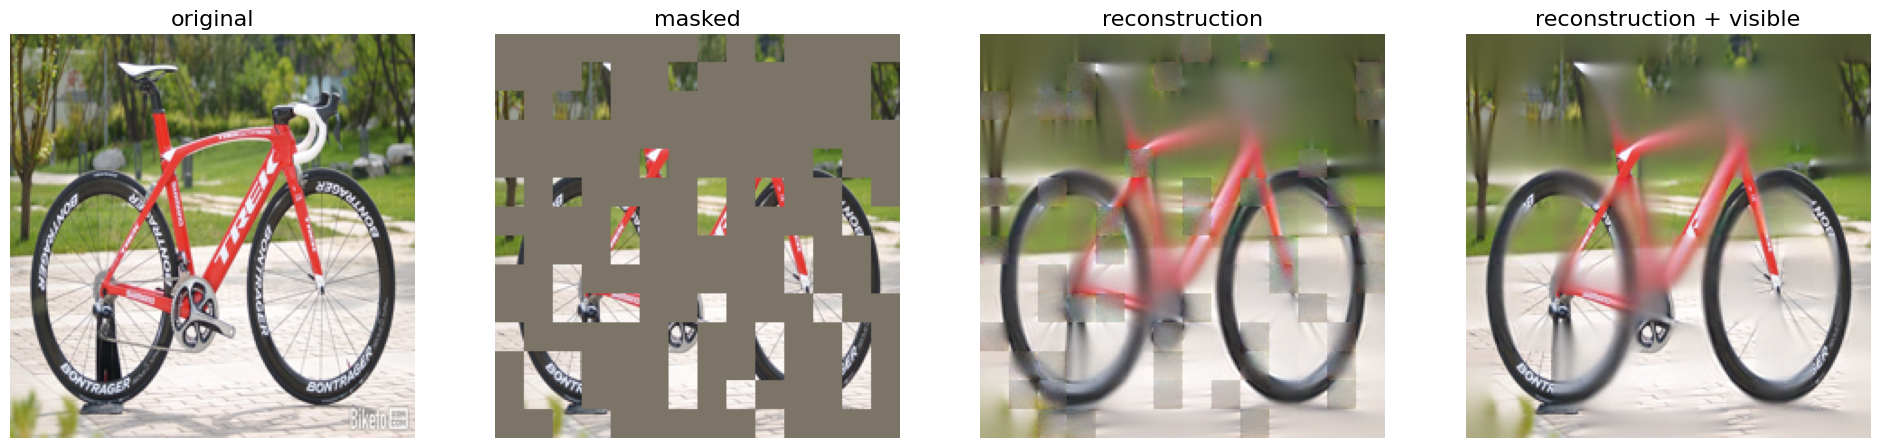

In [20]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

MAE with extra GAN loss:


NameError: name 'model_mae_gan' is not defined